This notebook is based on the tutorial: https://gmihaila.github.io/tutorial_notebooks/gpt2_finetune_classification/

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import Dataset, DataLoader, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.feature_extraction.text import TfidfVectorizer
from torchtext.vocab import GloVe,vocab
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          AlbertConfig,
                          AlbertTokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          AlbertForSequenceClassification,
                          AlbertPreTrainedModel,
                          AlbertModel)
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, classification_report
from typing import Optional, Tuple, Union
from transformers.modeling_outputs import SequenceClassifierOutputWithPast, SequenceClassifierOutput

%matplotlib inline

In [2]:
# Local env directory change
# %cd F:/temp/AML/1/
# !pwd

print(torch.cuda.is_available())

!ls "../input/mbti-personality-types-500-dataset/MBTI 500.csv"

True
'../input/mbti-personality-types-500-dataset/MBTI 500.csv'


In [3]:
def download_file(fn):
  download_fn = f'https://storage.googleapis.com/atomic-bird-188013.appspot.com/MBTI/{fn}'
  !curl { download_fn } -o {fn}

In [4]:
def convert_personality_type_to_binary(mbti_type):
    mapper = {
        'I':0,
        'E':1,
        'N':0,
        'S':1,
        'T':0,
        'F':1,
        'J':0,
        'P':1,
    }

    return [mapper[i] for i in mbti_type]

def convert_personality_type_to_int(mbti_type):
    types = [
                'INTJ', 'INTP', 'ISFJ', 'ISFP',
                'ISTJ', 'ISTP', 'ENFJ', 'ENFP',
                'ENTJ', 'ENTP','ESFJ', 'ESFP',
                'ESTJ', 'ESTP', 'INFJ', 'INFP'
            ]
    ints = [i for i in range(len(types))]
    mapper = dict(zip(types, ints))

    return mapper[mbti_type]

def convert_binary_to_personality_type(binary_mbti_type):
    mbti_arrays = [['I', 'E'], ['N', 'S'], ['T', 'F'], ['J', 'P']]
    mbti_string = ''
    for idx, mbti_type in enumerate(binary_mbti_type):
        mbti_string += mbti_arrays[idx][int(mbti_type)]
    return mbti_string

In [5]:
class MBTIDataset(Dataset):
    def __init__(self, data_path, vectorizing_method = None, binary_outputs = False, max_seq_len=500):
        """
        Vectorizing methods:
        None - returns raw text
        basic - basic builtin pytorch vectorizer
        TfIdf - tf-idf vectorizer
        GloVe - Global Vectors pretrained embedding
        """
        self.df = pd.read_csv(data_path)
        self.vectorizing_method = vectorizing_method
        self.max_seq_len = max_seq_len
        self.split_dataframe(self.max_seq_len)

        if vectorizing_method:
            if vectorizing_method.lower == 'basic':
                self.tokenizer = get_tokenizer('basic_english')
                self.vocab = build_vocab_from_iterator(self.yield_tokens_from_dataframe(), specials=['<unk>'])
                self.vocab.set_default_index(self.vocab["<unk>"])

            if vectorizing_method.lower == 'tfidf' or vectorizing_method.lower == 'tf-idf':
                self.tokenizer = TfidfVectorizer(stop_words= 'english')
                self.vocab = self.tokenizer.fit_transform(self.df['posts']) # Sparse matrix representation - could use different field names
            if vectorizing_method.lower == 'glove':
                unk_index = 0
                self.global_vectors = GloVe(name='6B', dim=50)
                self.vocab=vocab(self.global_vectors.stoi)
                self.vocab.insert_token("<unk>",unk_index)
                self.vocab.set_default_index(unk_index)

                self.pretrained_embeddings = self.global_vectors.vectors
                self.pretrained_embeddings = torch.cat((torch.zeros(1,self.pretrained_embeddings.shape[1]),self.pretrained_embeddings))


        self.binary_outputs = binary_outputs
        if binary_outputs:
            self.df['type'] = self.df['type'].apply(convert_personality_type_to_binary)
        else:
            self.df['type'] = self.df['type'].apply(convert_personality_type_to_int)

    def yield_tokens_from_dataframe(self):
        for post in self.df['posts']:
            yield self.tokenizer(post)

    def split_dataframe(self, new_seq_len):
        new_df = pd.DataFrame(columns=self.df.columns)
        new_posts = []
        new_types = []
        for idx, row in self.df.iterrows():
            split_posts = row['posts'].split(' ')[0:500]
            i = 0
            while i < len(split_posts):
                new_posts.append((' ').join(split_posts[i:i+new_seq_len]))
                new_types.append(row['type'])
                i += new_seq_len

        new_df['posts'] = new_posts
        new_df['type'] = new_types
        self.df = new_df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if idx >= len(self): raise IndexError

        if not self.vectorizing_method :
            return self.df['posts'][idx], self.df['type'][idx]  #Return raw text

        input_text = self.vocab(self.df['posts'][idx].split(' '))
        if len(input_text) < self.max_seq_len:
            input_text.extend([0] * (self.max_seq_len-len(input_text)))
        label = self.df['type'][idx]

        return input_text[0:self.max_seq_len], label

In [6]:
class AlbertClassificationCollator(object):

    def __init__(self, use_tokenizer, max_sequence_len=None):

        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len

    def __call__(self, sequences):

        texts = [sequence[0] for sequence in sequences]
        labels = [sequence[1] for sequence in sequences]
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        inputs.update({'labels':torch.tensor(labels)})

        return inputs

## Integer outputs

In [7]:
max_seq_len = 500
model_name = "albert-base-v2"

tokenizer = AlbertTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
albert_classification_collator = AlbertClassificationCollator(use_tokenizer=tokenizer, max_sequence_len=max_seq_len)

ds = MBTIDataset('../input/mbti-personality-types-500-dataset/MBTI 500.csv', vectorizing_method = None, binary_outputs=False, max_seq_len = max_seq_len)
train_set_size = int(len(ds)*0.7)
val_set_size = int(len(ds)*0.2)
test_set_size = len(ds) - train_set_size - val_set_size
train_ds, val_ds, test_ds = random_split(ds, [train_set_size, val_set_size, test_set_size])

train_dataloader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=albert_classification_collator)
val_dataloader = DataLoader(val_ds, batch_size=8, shuffle=True, collate_fn=albert_classification_collator)
test_dataloader = DataLoader(test_ds, batch_size=8, shuffle=True, collate_fn=albert_classification_collator)

Downloading:   0%|          | 0.00/742k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [8]:
n_labels = 16
model_config = AlbertConfig.from_pretrained(model_name, num_labels=n_labels)

tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model = AlbertForSequenceClassification.from_pretrained(model_name, config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id


Downloading:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(),lr = 2e-5,eps = 1e-8)

epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

cuda


In [ ]:
for epoch in range(epochs):
    model.train()
    predictions_labels = []
    true_labels = []
    total_loss = 0
    
    # Training loop
    for batch in tqdm(train_dataloader, total=len(train_dataloader), position=0, leave=True):

        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        model.zero_grad()
        outputs = model(**batch)
        loss, logits = outputs[:2]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        logits = logits.detach().cpu().numpy()
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()
                  
    avg_epoch_loss = total_loss / len(train_dataloader)
    print('Train loss:', avg_epoch_loss)
    
    model.eval()
    predictions_labels = []
    true_labels = []
    total_val_loss = 0
    
    # Validation loop
    for batch in tqdm(val_dataloader, total=len(val_dataloader), position=0, leave=True):

        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        with torch.no_grad():        
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_val_loss += loss.item()
            predict_content = logits.argmax(axis=-1).flatten().tolist()
            predictions_labels += predict_content

    avg_epoch_val_loss = total_val_loss / len(val_dataloader)
    print('Validation loss:', avg_epoch_val_loss)
    
    #Save model and later load the one with the least validation loss
    torch.save(model.state_dict(), f'./albertv2_epoch_{epoch}_val_loss_{avg_epoch_val_loss}.pt')

100%|██████████| 9281/9281 [2:13:14<00:00,  1.16it/s]  


Train loss: 0.8745251029073372


100%|██████████| 2652/2652 [15:42<00:00,  2.81it/s]


Validation loss: 0.6555767519516115


100%|██████████| 9281/9281 [2:13:29<00:00,  1.16it/s]  


Train loss: 0.584565618084261


100%|██████████| 2652/2652 [15:46<00:00,  2.80it/s]


Validation loss: 0.5851288151772424


100%|██████████| 9281/9281 [2:13:42<00:00,  1.16it/s]  


Train loss: 0.4635370176228759


100%|██████████| 2652/2652 [15:48<00:00,  2.80it/s]


Validation loss: 0.5793222425770921


100%|██████████| 9281/9281 [2:13:36<00:00,  1.16it/s]  


Train loss: 0.3585611477974038


100%|██████████| 2652/2652 [15:43<00:00,  2.81it/s]


Validation loss: 0.758267263473772


 89%|████████▉ | 8252/9281 [1:58:47<14:53,  1.15it/s]  

In [10]:
best_loss_integer_model_filename = 'albertv2_epoch_2_val_loss_0.5793222425770921.pt'

# USE when running dry
download_file(best_loss_integer_model_filename)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44.6M  100 44.6M    0     0  41.3M      0  0:00:01  0:00:01 --:--:-- 41.3M


In [11]:
#Load the best model and put it into evaluation mode
!ls -l
model.load_state_dict(torch.load(f'./{best_loss_integer_model_filename}'))
model.eval()

total 762660
---------- 1 root root      263 Dec 20 20:19 __notebook_source__.ipynb
-rw-r--r-- 1 root root 44399505 Dec 20 20:19 albertv2_binary_epoch_0_val_loss_0.26324948621351907.pt
-rw-r--r-- 1 root root 44399505 Dec 20 20:19 albertv2_binary_epoch_0_val_loss_0.31263704598511866.pt
-rw-r--r-- 1 root root 46762571 Dec 20 20:19 albertv2_binary_epoch_0_val_loss_0.5447556507263788.pt
-rw-r--r-- 1 root root 46762571 Dec 20 20:19 albertv2_binary_epoch_0_val_loss_0.5448292325142642.pt
-rw-r--r-- 1 root root 44399505 Dec 20 20:19 albertv2_binary_epoch_1_val_loss_0.23792667651540553.pt
-rw-r--r-- 1 root root 46762571 Dec 20 20:19 albertv2_binary_epoch_1_val_loss_0.5445631526713997.pt
-rw-r--r-- 1 root root 46762571 Dec 20 20:19 albertv2_binary_epoch_1_val_loss_0.5445966042836687.pt
-rw-r--r-- 1 root root 44399505 Dec 20 20:19 albertv2_binary_epoch_2_val_loss_0.24559779805700163.pt
-rw-r--r-- 1 root root 46762571 Dec 20 20:19 albertv2_binary_epoch_2_val_loss_0.5445430317435689.pt
-rw-r--r-- 1

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [12]:
model.eval()
predictions_labels = []
true_labels = []
total_test_loss = 0

# Testing loop
for batch in tqdm(test_dataloader, total=len(test_dataloader)):

    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
    with torch.no_grad():        
        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_test_loss += loss.item()
        predict_content = logits.argmax(axis=-1).flatten().tolist()
        predictions_labels += predict_content

avg_test_loss = total_test_loss / len(test_dataloader)
print(avg_test_loss)

100%|██████████| 1326/1326 [04:39<00:00,  4.75it/s]

0.393804304054861


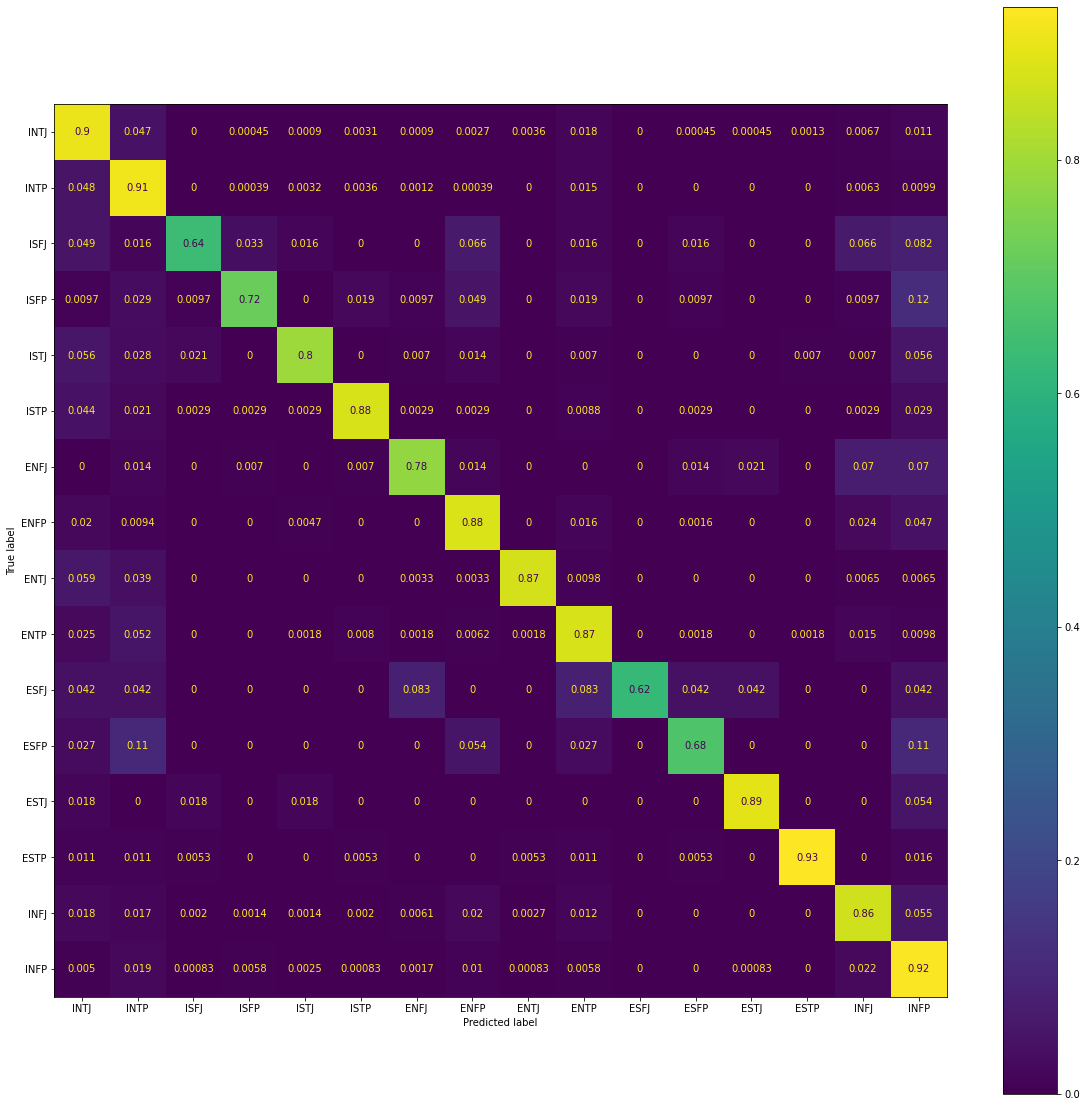

In [13]:
mbti_types = [
                'INTJ', 'INTP', 'ISFJ', 'ISFP',
                'ISTJ', 'ISTP', 'ENFJ', 'ENFP',
                'ENTJ', 'ENTP','ESFJ', 'ESFP',
                'ESTJ', 'ESTP', 'INFJ', 'INFP'
            ]

fig, ax = plt.subplots(figsize=(20, 20))
cm = confusion_matrix(true_labels, predictions_labels, labels=[i for i in range(16)], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mbti_types)
disp.plot(ax=ax)


In [14]:
print('Accuracy:', accuracy_score(true_labels, predictions_labels))
print('F1 score:', f1_score(true_labels, predictions_labels, average='weighted'))
print('Precision:', precision_score(true_labels, predictions_labels, average='weighted'))
print('Recall:', recall_score(true_labels, predictions_labels, average='weighted'))


Accuracy: 0.8883861236802413
F1 score: 0.8882004217843457
Precision: 0.8893996106190625
Recall: 0.8883861236802413


## Binary outputs

In [15]:
class AlbertForBinaryMBTIClassification(AlbertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.transformer = AlbertModel(config, add_pooling_layer=False)
        self.EI = nn.Linear(config.hidden_size, 1, bias=False)
        self.NS = nn.Linear(config.hidden_size, 1, bias=False)
        self.TF = nn.Linear(config.hidden_size, 1, bias=False)
        self.JP = nn.Linear(config.hidden_size, 1, bias=False)

        # Model parallel
        self.model_parallel = False
        self.device_map = None

        # Initialize weights and apply final processing
        self.post_init()
        
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.Tensor]]] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        # use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutput]:
        
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        transformer_outputs = self.transformer(
            input_ids,
            #past_key_values=past_key_values,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            # use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        
        hidden_states = transformer_outputs[0] # probably the last hidden state we need
        #print(transformer_outputs)
        logits = torch.cat((self.EI(hidden_states), self.NS(hidden_states), self.TF(hidden_states), self.JP(hidden_states)), 2)
        
        if input_ids is not None:
            batch_size, sequence_length = input_ids.shape[:2]
        else:
            batch_size, sequence_length = inputs_embeds.shape[:2]
        
        pooled_logits = logits[torch.arange(batch_size, device=logits.device), -1]
        
        loss = None
        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            #print(pooled_logits.detach().cpu().numpy()
            loss = loss_fct(pooled_logits, labels.float())

        if not return_dict:
            output = (pooled_logits,) + transformer_outputs[1:]
            return ((loss,) + output) if loss is not None else output
        
        # output_hidden_states 
        return SequenceClassifierOutput(
        # return SequenceClassifierOutputWithPast( # NOTE: SequenceClassifierOutputWithPast is not supported in Albert model
            loss=loss,
            logits=pooled_logits,
            # past_key_values=transformer_outputs.past_key_values, # NOTE: past_key_values are not supported in Albert model
            hidden_states=transformer_outputs.hidden_states,
            attentions=transformer_outputs.attentions,
        )

In [16]:
max_seq_len = 500
model_name = "albert-base-v2"

tokenizer = AlbertTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
albert_classification_collator = AlbertClassificationCollator(use_tokenizer=tokenizer, max_sequence_len=max_seq_len)

ds = MBTIDataset('../input/mbti-personality-types-500-dataset/MBTI 500.csv', vectorizing_method = None, binary_outputs=True, max_seq_len = max_seq_len)
train_set_size = int(len(ds)*0.7)
val_set_size = int(len(ds)*0.2)
test_set_size = len(ds) - train_set_size - val_set_size
train_ds, val_ds, test_ds = random_split(ds, [train_set_size, val_set_size, test_set_size])

train_dataloader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=albert_classification_collator)
val_dataloader = DataLoader(val_ds, batch_size=8, shuffle=True, collate_fn=albert_classification_collator)
test_dataloader = DataLoader(test_ds, batch_size=8, shuffle=True, collate_fn=albert_classification_collator)

In [17]:
n_labels = 1

model_config = AlbertConfig.from_pretrained(model_name, num_labels=n_labels)

tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model = AlbertForBinaryMBTIClassification.from_pretrained(model_name, config=model_config)
#model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForBinaryMBTIClassification: ['predictions.LayerNorm.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.ffn_output.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.LayerNorm.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.weight', 'predictions.dense.bias', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.value.bias', 'albert.encoder.embedding_hidden_mapping_in.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.value.weight', 'predictions.LayerNorm.weight', 'albert.embeddings.LayerNorm.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight', 'albert.encoder.albert_layer_groups.0.albert_layers.0.ffn_output.weight', 'albert.embeddings.LayerNorm.bias', 'albert.encoder.albert_layer_groups.

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

cuda


In [120]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for batch in tqdm(train_dataloader, total=len(train_dataloader), position=0, leave=True):

        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        model.zero_grad()
        outputs = model(**batch)
        loss, logits = outputs[:2]
        # print(logits.detach().cpu().numpy())
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_epoch_loss = total_loss / len(train_dataloader)
    print('Train loss:', avg_epoch_loss)
    
    model.eval()
    total_loss = 0

    for batch in tqdm(val_dataloader, total=len(val_dataloader), position=0, leave=True):

        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        with torch.no_grad():        
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss += loss.item()

    avg_epoch_val_loss = total_loss / len(val_dataloader)
    print('Validation loss:', avg_epoch_val_loss)
    
    #Save model and later load the one with the least validation loss
    torch.save(model.state_dict(), f'./albertv2_binary_epoch_{epoch}_val_loss_{avg_epoch_val_loss}.pt')

100%|██████████| 9281/9281 [1:16:37<00:00,  2.02it/s]


Train loss: 0.30182142923446087


100%|██████████| 2652/2652 [09:09<00:00,  4.82it/s]


Validation loss: 0.26324948621351907


100%|██████████| 9281/9281 [1:16:55<00:00,  2.01it/s]


Train loss: 0.24599742592838114


100%|██████████| 2652/2652 [09:09<00:00,  4.82it/s]


Validation loss: 0.23792667651540553


100%|██████████| 9281/9281 [1:16:52<00:00,  2.01it/s]


Train loss: 0.2136129291827282


100%|██████████| 2652/2652 [09:11<00:00,  4.81it/s]


Validation loss: 0.24559779805700163


100%|██████████| 9281/9281 [1:16:53<00:00,  2.01it/s]


Train loss: 0.18696001775022092


100%|██████████| 2652/2652 [09:10<00:00,  4.81it/s]


Validation loss: 0.23292770812538668


100%|██████████| 9281/9281 [1:16:47<00:00,  2.01it/s]


Train loss: 0.16527507833604846


100%|██████████| 2652/2652 [09:04<00:00,  4.87it/s]


Validation loss: 0.2323680259011683


In [19]:
best_loss_binary_model_filename = 'albertv2_binary_epoch_4_val_loss_0.2323680259011683.pt'

# USE when running dry
download_file(best_loss_binary_model_filename)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42.3M  100 42.3M    0     0  41.7M      0  0:00:01  0:00:01 --:--:-- 41.7M


In [20]:
!ls -l
model.load_state_dict(torch.load(f'./{best_loss_binary_model_filename}'))
model.eval()


total 762660
---------- 1 root root      263 Dec 20 20:19 __notebook_source__.ipynb
-rw-r--r-- 1 root root 44399505 Dec 20 20:19 albertv2_binary_epoch_0_val_loss_0.26324948621351907.pt
-rw-r--r-- 1 root root 44399505 Dec 20 20:19 albertv2_binary_epoch_0_val_loss_0.31263704598511866.pt
-rw-r--r-- 1 root root 46762571 Dec 20 20:19 albertv2_binary_epoch_0_val_loss_0.5447556507263788.pt
-rw-r--r-- 1 root root 46762571 Dec 20 20:19 albertv2_binary_epoch_0_val_loss_0.5448292325142642.pt
-rw-r--r-- 1 root root 44399505 Dec 20 20:19 albertv2_binary_epoch_1_val_loss_0.23792667651540553.pt
-rw-r--r-- 1 root root 46762571 Dec 20 20:19 albertv2_binary_epoch_1_val_loss_0.5445631526713997.pt
-rw-r--r-- 1 root root 46762571 Dec 20 20:19 albertv2_binary_epoch_1_val_loss_0.5445966042836687.pt
-rw-r--r-- 1 root root 44399505 Dec 20 20:19 albertv2_binary_epoch_2_val_loss_0.24559779805700163.pt
-rw-r--r-- 1 root root 46762571 Dec 20 20:19 albertv2_binary_epoch_2_val_loss_0.5445430317435689.pt
-rw-r--r-- 1

AlbertForBinaryMBTIClassification(
  (transformer): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_featur

In [21]:
predictions_labels = []
true_labels = []
total_loss = 0

model.eval()


# Test loop
for batch in tqdm(test_dataloader, total=len(test_dataloader)):

    true_labels += batch['labels'].numpy().tolist()
    batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
    with torch.no_grad():        
        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach()
        total_loss += loss.item()
        predict_content = torch.round(torch.sigmoid(logits)).cpu().numpy().tolist()
        predictions_labels += predict_content

avg_epoch_loss = total_loss / len(test_dataloader)
print(avg_epoch_loss)

100%|██████████| 1326/1326 [04:37<00:00,  4.78it/s]

0.17988870898788434


In [22]:
y_true_array = np.array(true_labels)
y_pred_array = np.array(predictions_labels)

Results of ['I', 'E']:
Accuracy: 0.9292043740573153
F1 score: 0.928539333280321
Precision: 0.9282754632110187
Recall: 0.9292043740573153
Results of ['N', 'S']:
Accuracy: 0.967288838612368
F1 score: 0.9663986754259267
Precision: 0.966051194264938
Recall: 0.967288838612368
Results of ['T', 'F']:
Accuracy: 0.9412707390648567
F1 score: 0.9412572091171196
Precision: 0.9412445768647053
Recall: 0.9412707390648567
Results of ['J', 'P']:
Accuracy: 0.8977187028657617
F1 score: 0.8975600995337067
Precision: 0.8975431245966051
Recall: 0.8977187028657617


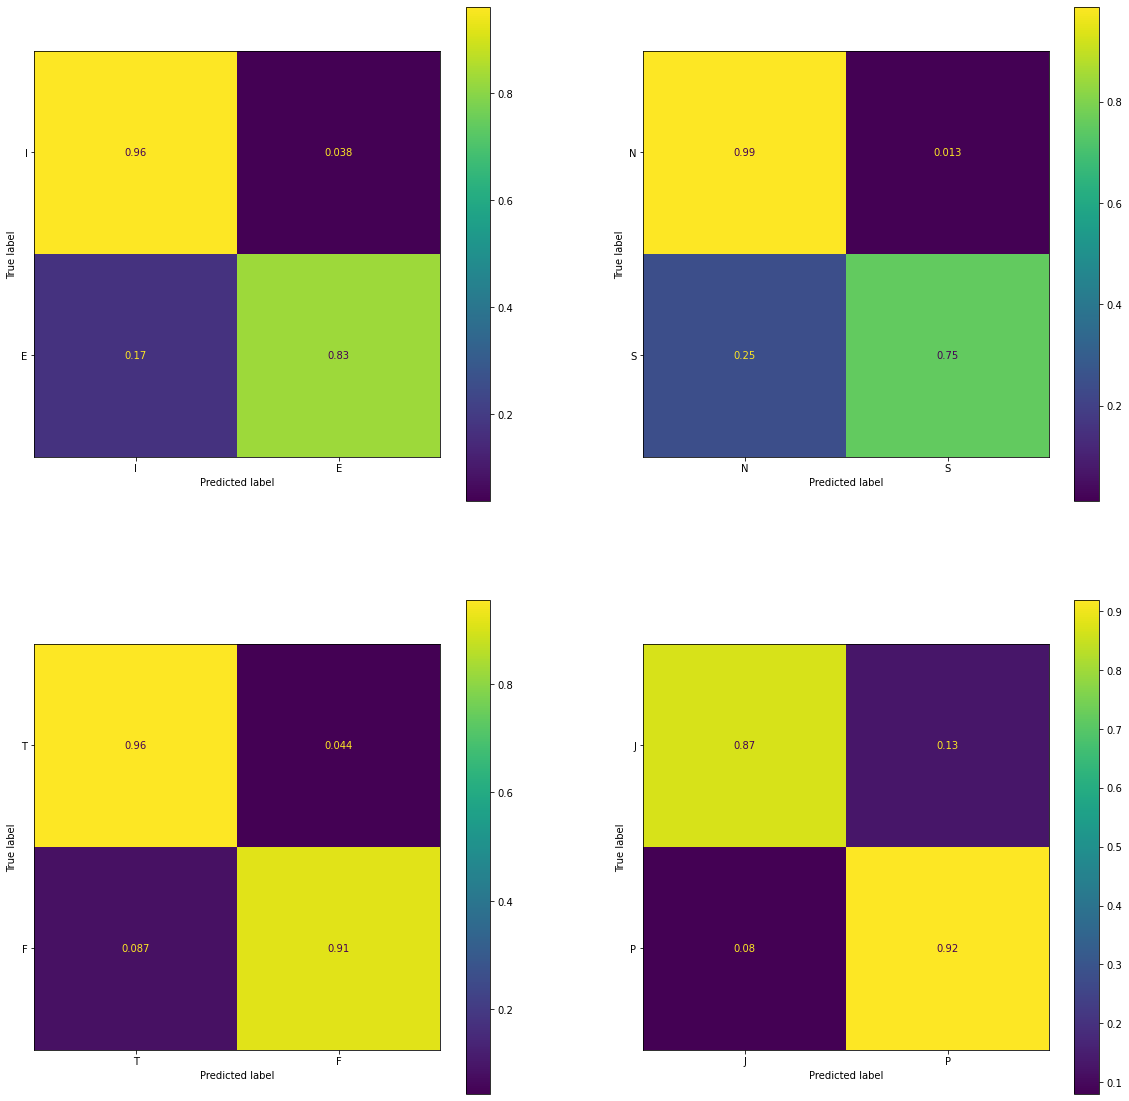

In [23]:
mbti_arrays = [['I', 'E'], ['N', 'S'], ['T', 'F'], ['J', 'P']]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))
axes = [ax1, ax2, ax3, ax4]
for i in range(4):
    cm = confusion_matrix(y_true_array[:, i], y_pred_array[:, i], labels=[0, 1], normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mbti_arrays[i])
    disp.plot(ax=axes[i])
    
for i in range(4):
    print(f'Results of {mbti_arrays[i]}:')
    print('Accuracy:', accuracy_score(y_true_array[:, i], y_pred_array[:, i]))
    print('F1 score:',f1_score(y_true_array[:, i], y_pred_array[:, i], average='weighted'))
    print('Precision:',precision_score(y_true_array[:, i], y_pred_array[:, i], average='weighted'))
    print('Recall:',recall_score(y_true_array[:, i], y_pred_array[:, i], average='weighted'))

In [24]:
y_true_ints = [convert_personality_type_to_int(convert_binary_to_personality_type(i)) for i in y_true_array]
y_pred_ints = [convert_personality_type_to_int(convert_binary_to_personality_type(i)) for i in y_pred_array]

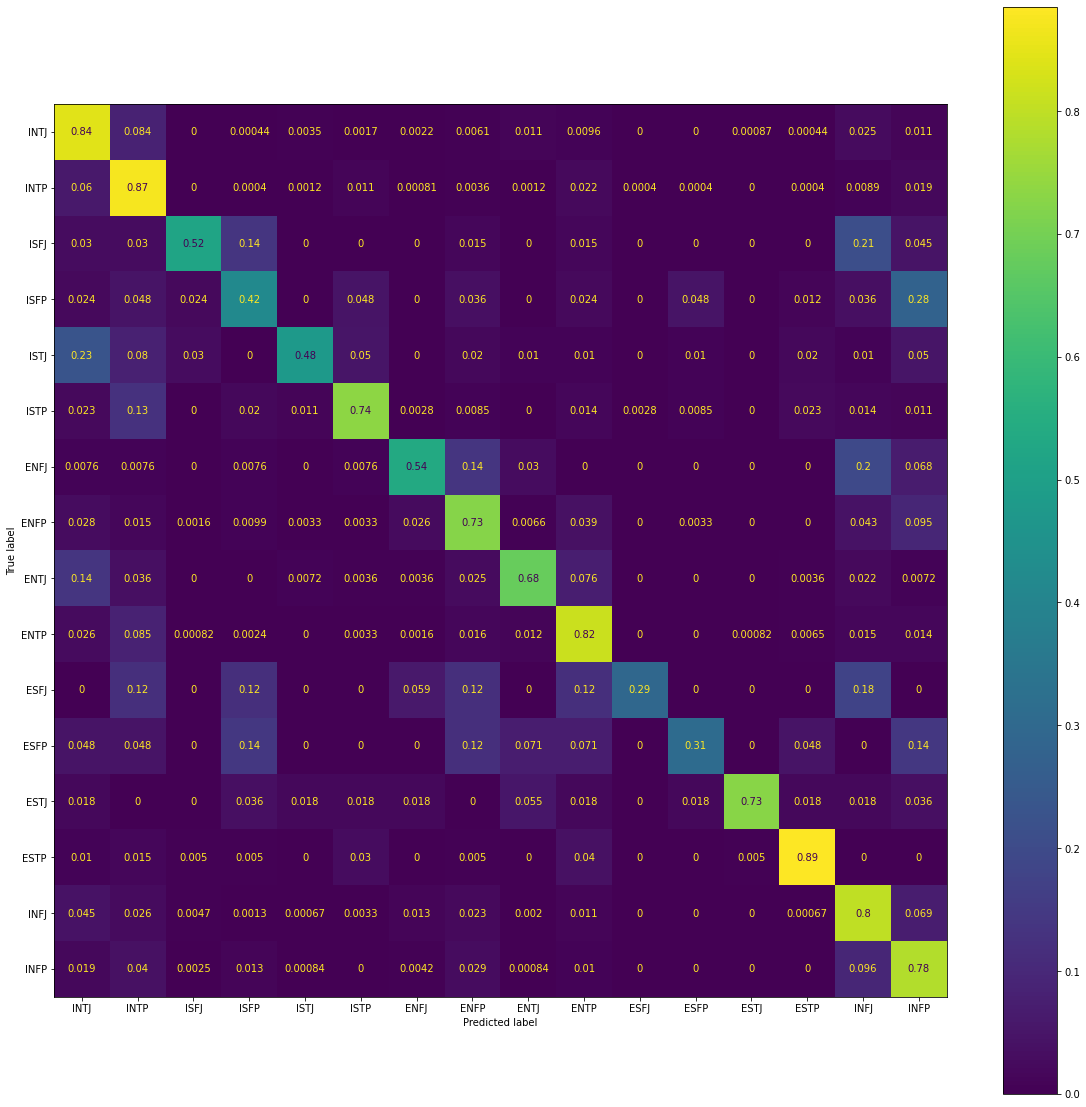

In [25]:
mbti_types = [
                'INTJ', 'INTP', 'ISFJ', 'ISFP',
                'ISTJ', 'ISTP', 'ENFJ', 'ENFP',
                'ENTJ', 'ENTP','ESFJ', 'ESFP',
                'ESTJ', 'ESTP', 'INFJ', 'INFP'
            ]

fig, ax = plt.subplots(figsize=(20, 20))
cm = confusion_matrix(y_true_ints, y_pred_ints, labels=[i for i in range(16)], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mbti_types)
disp.plot(ax=ax)

In [26]:
print('Accuracy:', accuracy_score(y_true_ints, y_pred_ints))
print('F1 score:',f1_score(y_true_ints, y_pred_ints, average='weighted'))
print('Precision:',precision_score(y_true_ints, y_pred_ints, average='weighted'))
print('Recall:', recall_score(y_true_ints, y_pred_ints, average='weighted'))

Accuracy: 0.8041101055806938
F1 score: 0.8028268421011574
Precision: 0.8033470363247237
Recall: 0.8041101055806938
